###**FDA JCOMP STOCK MARKET PREDICTION**

In [ ]:
pip install nsepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##DATA PROCESSING

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nsepy import get_history
from datetime import date
from nsepy.history import get_price_list,get_indices_price_list
import datetime as dt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,10
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from xgboost import plot_importance
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV,KFold
from ta.momentum import RSIIndicator,StochasticOscillator
# from fastai.tabular import add_datepart
from fastai.imports import *
import seaborn as sns
import altair as alt
sns.set()
%matplotlib inline

#remove warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv("TCS.csv")

In [ ]:
price = get_price_list(dt=date(2015,1,1))

In [ ]:
data = get_history(symbol="TCS", start=date(2015,1,1), end=date(2016,12,31))

In [ ]:
data.tail()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2016-12-26,TCS,EQ,2288.1,2266.0,2301.6,2266.00,2296.85,2293.10,2290.60,448704,1.027802e+14,29524,213160,0.4751
2016-12-27,TCS,EQ,2293.1,2281.5,2330.0,2281.50,2322.80,2323.40,2317.79,647346,1.500411e+14,42719,358760,0.5542
2016-12-28,TCS,EQ,2323.4,2326.7,2349.9,2303.15,2305.25,2313.40,2335.86,675209,1.577194e+14,65267,420288,0.6225
2016-12-29,TCS,EQ,2313.4,2303.0,2359.9,2303.00,2355.00,2351.70,2346.25,981758,2.303445e+14,64945,575262,0.5860
2016-12-30,TCS,EQ,2351.7,2354.9,2378.6,2345.65,2366.55,2365.55,2366.64,702874,1.663448e+14,44979,456203,0.6491


In [ ]:
data_new=data.drop(['Symbol', 'Series','Last', 'VWAP', 'Turnover', 'Trades', 'Deliverable Volume', '%Deliverble'],axis=1)

In [ ]:
def ChangeIndex(share):
  '''Changes Date index to datetime datatype'''
  share.index = pd.to_datetime(share.index) # chane index to datetime format
  pass

In [ ]:
ChangeIndex(data_new)

In [ ]:
data_new.reset_index(inplace=True)

In [ ]:
data_new.head()

,Date,Prev Close,Open,High,Low,Close,Volume
0,2015-01-01,2558.25,2567.0,2567.00,2541.00,2545.55,183415
1,2015-01-02,2545.55,2551.0,2590.95,2550.60,2579.45,462870
2,2015-01-05,2579.45,2581.0,2599.90,2524.65,2540.25,877121
3,2015-01-06,2540.25,2529.1,2529.10,2440.00,2446.60,1211892
4,2015-01-07,2446.60,2470.0,2479.15,2407.45,2417.70,1318166


In [ ]:
alt.Chart(data_new).mark_line(color='blue').encode(x='Date', y='Close' ).properties(height=400, width=1000 )

alt.Chart(...)

##FEATURE ENGINEERING

In [ ]:
from fastai.tabular.core import add_datepart

In [ ]:
add_datepart(data_new, 'Date', drop=False)
data_new.drop('Elapsed', axis=1, inplace=True)

In [ ]:
def featurecalculator(share):
  share['EMA_9'] = share['Close'].ewm(9).mean() # exponential moving average of window 9
  share['SMA_5'] = share['Close'].rolling(5).mean() # moving average of window 5
  share['SMA_10'] = share['Close'].rolling(10).mean() # moving average of window 10
  share['SMA_15'] = share['Close'].rolling(15).mean() # moving average of window 15
  share['SMA_20'] = share['Close'].rolling(20).mean() # moving average of window 20
  share['SMA_25'] = share['Close'].rolling(25).mean() # moving average of window 25
  share['SMA_30'] = share['Close'].rolling(30).mean() # moving average of window 30
  EMA_12 = pd.Series(share['Close'].ewm(span=12, min_periods=12).mean())
  EMA_26 = pd.Series(share['Close'].ewm(span=26, min_periods=26).mean())
  share['MACD'] = pd.Series(EMA_12 - EMA_26)    # calculates Moving Average Convergence Divergence
  share['RSI'] = RSIIndicator(share['Close']).rsi() # calculates Relative Strength Index 
  share['Stochastic']=StochasticOscillator(share['High'],share['Low'],share['Close']).stoch() # Calculates Stochastic Oscillator
  pass

In [ ]:
featurecalculator(data_new)

In [ ]:
def labelencode(share):
  LE=LabelEncoder()
  # share['Is_month_end']=LE.fit_transform(share['Is_month_end'])
  share['Is_month_start']=LE.fit_transform(share['Is_month_start'])
  share['Is_quarter_end']=LE.fit_transform(share['Is_quarter_end'])
  share['Is_quarter_start']=LE.fit_transform(share['Is_quarter_start'])
  share['Is_year_end']=LE.fit_transform(share['Is_year_end'])
  share['Is_year_start']=LE.fit_transform(share['Is_year_start'])

  pass

In [ ]:
labelencode(data_new)

In [ ]:
# Dropping rows with Na values
data_new=data_new.iloc[33:]

In [ ]:
data_new.reset_index(drop=True,inplace=True)

In [ ]:
data_new.head(10)

,Close,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,...,EMA_9,SMA_5,SMA_10,SMA_15,SMA_20,SMA_25,SMA_30,MACD,RSI,Stochastic
0,2681.05,2,8,19,3,50,False,0,0,0,...,2544.512458,2580.48,2544.450,2537.196667,2531.5275,2529.408,2520.553333,20.843289,66.295751,97.542273
1,2675.55,2,8,20,4,51,False,0,0,0,...,2557.952641,2623.16,2556.765,2545.923333,2539.6150,2535.552,2529.148333,27.935238,65.476238,91.252822
2,2696.65,2,9,23,0,54,False,0,0,0,...,2572.142041,2654.74,2568.855,2560.230000,2548.7700,2541.854,2537.576667,34.747787,67.153730,91.228374
3,2704.75,2,9,24,1,55,False,0,0,0,...,2585.677271,2678.73,2588.040,2572.933333,2558.8275,2548.758,2543.991667,40.289792,67.800543,91.498316
4,2672.20,2,9,25,2,56,False,0,0,0,...,2594.490366,2686.04,2611.145,2580.530000,2567.3350,2555.206,2549.408333,41.694729,62.476296,80.538721
5,2656.45,2,9,26,3,57,False,0,0,0,...,2600.789786,2681.12,2630.800,2590.006667,2573.1775,2561.446,2554.693333,41.116357,60.020247,75.235690
6,2662.35,2,9,27,4,58,False,0,0,0,...,2607.038164,2678.48,2650.820,2597.336667,2579.0625,2567.388,2559.373333,40.642396,60.644391,77.222222
7,2675.25,2,9,28,5,59,True,0,0,0,...,2613.951311,2674.20,2664.470,2603.970000,2588.7225,2573.856,2563.911667,40.793755,62.039780,81.565657
8,2669.40,3,10,2,0,61,False,0,0,0,...,2619.563371,2667.13,2672.930,2614.403333,2596.4825,2580.488,2568.486667,39.994839,60.983804,78.586572
9,2776.00,3,10,3,1,62,False,0,0,0,...,2635.377434,2687.89,2686.965,2636.726667,2607.3700,2591.446,2577.320000,47.127669,70.752873,95.918367


In [ ]:
data_new.drop(['Year','High','Low','Open','Prev Close','Volume','Date'],axis=1)

In [ ]:
# Shifting the features a row up
data_new[['EMA_9', 'SMA_5', 'SMA_10', 'SMA_15',
       'SMA_20', 'SMA_25', 'SMA_30', 'MACD', 'RSI', 'Stochastic']]=data_new[['EMA_9', 'SMA_5', 'SMA_10', 'SMA_15',
       'SMA_20', 'SMA_25', 'SMA_30', 'MACD', 'RSI', 'Stochastic']].shift(-1)

##TRAIN TEST SPLIT

In [ ]:
# Splitting the dataset into 70% training, 15% validation and 15% test
# train test split indexes
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(data_new.shape[0] * (1-test_size))
valid_split_idx = int(data_new.shape[0] * (1-(valid_size+test_size)))  


#train test split tcs

train= data_new.loc[:valid_split_idx]
valid= data_new.loc[valid_split_idx+1:test_split_idx]
test= data_new.loc[test_split_idx+1:]

In [ ]:
y_train = train['Close']
X_train = train.drop(['Close'], 1)

y_valid = valid['Close']
X_valid = valid.drop(['Close'], 1)

y_test = test['Close']
X_test = test.drop(['Close'], 1)

##XGBOOST MODEL

In [ ]:
parameters = {
    'n_estimators': [500,600],
    'learning_rate': [0.1],
    'max_depth': [8, 12, 15],
    'gamma': [ 0.005, 0.01,],
    'random_state': [42],
    'min_child_weight':[4,3],
    'subsample':[0.8,1],
    'colsample_bytree':[1],
    'colsample_bylevel':[1]
}
kfold=KFold(5)
eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = XGBRegressor(objective='reg:squarederror',n_jobs=-1)
clf = GridSearchCV(model, parameters,cv=kfold,scoring='neg_mean_absolute_error',verbose=0)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 12, 'min_child_weight': 3, 'n_estimators': 600, 'random_state': 42, 'subsample': 0.8}
Best validation score = -21.5576460125263


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Month             324 non-null    int64  
 1   Week              324 non-null    int64  
 2   Day               324 non-null    int64  
 3   Dayofweek         324 non-null    int64  
 4   Dayofyear         324 non-null    int64  
 5   Is_month_end      324 non-null    bool   
 6   Is_month_start    324 non-null    int64  
 7   Is_quarter_end    324 non-null    int64  
 8   Is_quarter_start  324 non-null    int64  
 9   Is_year_end       324 non-null    int64  
 10  Is_year_start     324 non-null    int64  
 11  EMA_9             324 non-null    float64
 12  SMA_5             324 non-null    float64
 13  SMA_10            324 non-null    float64
 14  SMA_15            324 non-null    float64
 15  SMA_20            324 non-null    float64
 16  SMA_25            324 non-null    float64
 1

In [ ]:
model = XGBRegressor(**clf.best_params_, objective='reg:squarederror',n_jobs=-1)
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)
y_pred=model.predict(X_test)
mean_absolute_error(y_test,y_pred)

34.74509454257249

##Handtuning the hyperparameters

In [ ]:
params={'colsample_bylevel': 1,
 'colsample_bytree': 0.6,
 'gamma': 0.005,
 'learning_rate': 0.07,
 'max_depth': 10,
 'min_child_weight': 1,
 'n_estimators': 170,
 'random_state': 42,
 'subsample': 0.6}
eval_set = [(X_train, y_train), (X_valid, y_valid)]

In [ ]:
xgb=XGBRegressor(**params, objective='reg:squarederror',n_jobs=-1)
xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)
y_pred = xgb.predict(X_test)
mean_absolute_error(y_test, y_pred)

24.049744536911252

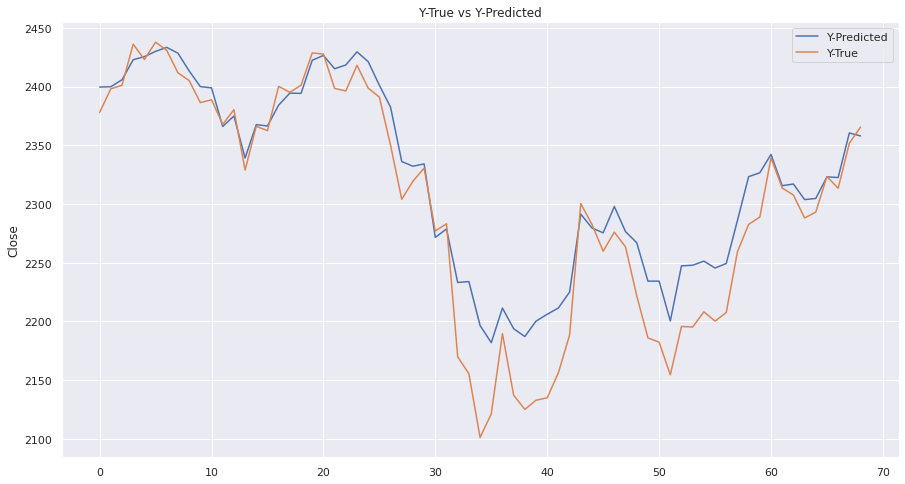

In [ ]:
plt.figure(figsize=(15,8))
sns.lineplot(y=y_pred,x=np.arange(69))
sns.lineplot(y=y_test,x=np.arange(69))
plt.legend(['Y-Predicted','Y-True'])
plt.title('Y-True vs Y-Predicted')
plt.show()